In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import spline

import ROOT
from ROOT import gROOT, gSystem, TFile, TGraphAsymmErrors, TH1, TF1, TFitResultPtr
import rootnotes
import rootprint

import plottingFunctions as pF
from astropy import units as u


default colormap is now ds9b


You are giving the normalization at 1.000
Yet the decorrelation energy is at  0.218
You might consider updating your normalization energy and rerunning.
You are giving the normalization at 1.000
Yet the decorrelation energy is at  0.191
You might consider updating your normalization energy and rerunning.


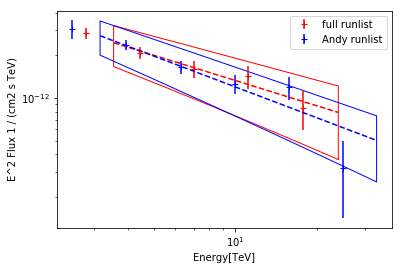

In [2]:
home = os.path.expanduser("~")
filename = home + "/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root"
spectrum = pF.spectrumPlotter()
spectrum.ReadVEGASs6Root(filename)
spectrum.plotSpectrum(label="full runlist") #xmin=0.1
spectrum.ReadVEGASs6Root(home+"/VERITAS/GC/results/stage6_Andy_SgrA_spectrum_SgrA_s6.root")
spectrum.plotSpectrum(label="Andy runlist", c='blue')



You have attempted to calculate the decorrelation energy but you don't 
have a covariance matrix - rerun to produce this.


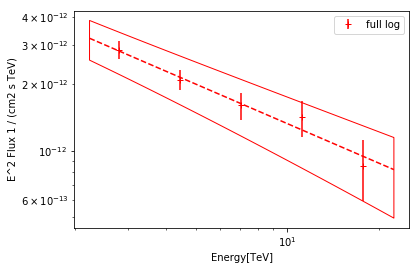

In [3]:
sp2 = pF.spectrumPlotter()
sp2.readVEGASLog(home+"/Dropbox/GalacticCenter/log/stage6/SgrA_disp5t_v255_okay-obs-4tel_medium_both_stage6.txt")
sp2.plotSpectrum(label="full log")

#help(plt.errorbar)

In [4]:
print spectrum.energyUnits.to_string()
energyUnits = u.TeV
sedUnits = (energyUnits * u.s**-1 * u.cm * u.cm)
print sedUnits.to_string()

TeV
cm2 TeV / s


In [5]:
ar = np.ndarray((2,5))
print ar
l1 = [1]*5
l2 = [2]*5

print np.asarray((l1, l2))


[[ 119.21079187  220.42362022  180.08231415  190.33083505  240.95006147]
 [ 164.89363996  301.79433263  152.96604227  362.68642909  104.07981525]]
[[1 1 1 1 1]
 [2 2 2 2 2]]


In [6]:
%%rootprint
vegasPath = os.path.expandvars("$VEGAS")
#vegasPath = "/home/mbuchove/Downloads"

# test with ROOT6
#gROOT.Reset()
gSystem.Load("libTreePlayer.so")
gSystem.Load("libPhysics.so")
gSystem.Load(vegasPath + "/common/lib/libSP24sharedLite.so")
gSystem.Load(vegasPath + "/resultsExtractor/lib/libStage6shared.so")
gSystem.AddIncludePath("-Wno-unused -Wno-shadow -Wno-unused-parameter")
gROOT.ProcessLine(".L " + vegasPath + "/common/include/VACommon.h")
gROOT.ProcessLine(".include " + vegasPath + "/common/include/")
gROOT.ProcessLine(".include " + vegasPath + "/resultsExtractor/include/")
gROOT.ProcessLine(".include " + vegasPath + "/cfitsio/include/")
    

#vacomm = VASpectrumAnl()
    
try:
    vegas_class = VACommon()
except:
    print "Unexpected error:", sys.exc_info()[0]
    _use_vegas = False
else:
    _use_vegas = True
    
    
print _use_vegas


Unexpected error: <type 'exceptions.NameError'>
False
reloading /home/mbuchove/VERITAS/base-ROOT5/VEGAS-v255/common/include/VACommon.h  0
reloading VAUsefulConversions.h  0
reloading cfloat  0
reloading float.h  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/TArchiveFile/P010_TZIPFile.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/TVirtualStreamerInfo/P010_TStreamerInfo.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P010_Minuit2Minimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P020_TMinuitMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P030_GSLMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P040_GSLNLSMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P050_GSLSimAn

In [7]:
home = os.path.expanduser("~")
filename = home + "/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root"
s6F = TFile(filename, "read")
if not s6F.IsOpen():
    print "Failure!"
specAn = s6F.Get("Spectrum/VASpectrumAnl")
#hMM = s6F.Get("Spectrum/hMigrationMatrix")
hFEH = s6F.Get("Spectrum/hFullExcessHist")
RBM = s6F.Get("RingBackgroundModelAnalysis")

specHist = specAn.GetSpectrumHist()
rebinned_specHist = specAn.GetRebinnedSpectrumHist()
specGraph = specAn.GetSpectrumGraph()



In [8]:
xaxis = specGraph.GetXaxis()
alpha = specAn.GetAlphaHist()
sig = specAn.GetSigmaHist()

In [9]:
type(specAn)
TFile.Open("gyih")
#sa = __main__.VASpectrumAnl()
arr = np.array((0,))
print arr[0]

0


In [10]:
def get_hist_points(h):
    """return E[TeV], flux[1/TeV*m^2*s], and flux_err as lists"""
    x, y, yerr = [], [], []
    for pt in range(1, h.GetNbinsX()+1):
        tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
        #h.GetPoint(pt, tmpX, tmpY)
        x.append(h.GetBinCenter(pt))
        y.append(h.GetBinContent(pt))
        yerr.append(h.GetBinError(pt))
        
    #print np.array(x), np.array(y), np.array(yerr)
    return np.power(10, np.array(x)), np.array(y), np.array(yerr)
# get_hist_points



In [11]:
xlab = specHist.GetXaxis().GetTitle()
ylab = specHist.GetYaxis().GetTitle()
print xlab

E, flux, flux_err = get_hist_points(rebinned_specHist)
print E
print flux
print flux_err

print type(specGraph)

E  [ Log10(TeV) ]
[  2.81838293   4.46683592   7.07945784  11.22018454  17.7827941 ]
[  3.64033803e-09   1.05522735e-09   3.23616467e-10   1.14158245e-10
   2.72773488e-11]
[  3.34238831e-10   1.08817913e-10   4.51352671e-11   2.11965827e-11
   8.43257755e-12]
<class 'ROOT.TGraphAsymmErrors'>


In [12]:
#%%rootprint
tf1 = specGraph.GetFunction("fFitFunction")
fitnorm = tf1.GetParameter(0)
fitindex = tf1.GetParameter(1)
normenergy = tf1.GetParameter(2)

r = specGraph.Fit(tf1, "S") #TFitResultPtr
#for i in range(3):
#    print tf1.GetParameter(i)
    
cov = r.GetCovarianceMatrix() #TMatrixTSym<double>
cov.Print()

var_norm = cov(0, 0)
var_index = cov(1, 1)
cov_normindex = cov(0, 1) # == (1, 0)

print np.sqrt(var_norm)
print np.sqrt(var_index)
print cov_normindex

#covarr = cov.GetMatrixArray()


9.44156106362e-09
0.113234169281
-1.01431019844e-09


In [13]:
npoints     = specGraph.GetN()

x2, y2 = [], []
y_err = []
for i in range(npoints):
    tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
    specGraph.GetPoint(i, tmpX, tmpY)
    x2.append(tmpX)
    y2.append(tmpY)
    y_err.append((specGraph.GetErrorYlow(i), specGraph.GetErrorYhigh(i)))
    
x2 = np.array(x2)
y2 = np.array(y2)
y_err = np.array(y_err)

print x2
print y2
print y_err

[  0.           0.           2.80374901   4.44364272   7.04269909
  11.16192585  17.69046029]
[  0.00000000e+00   0.00000000e+00   3.64033803e-09   1.05522735e-09
   3.23616467e-10   1.14158245e-10   2.72773488e-11]
[[  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  3.34238831e-10   3.34238831e-10]
 [  1.08817913e-10   1.08817913e-10]
 [  4.51352671e-11   4.51352671e-11]
 [  2.11965827e-11   2.11965827e-11]
 [  8.43257755e-12   8.43257755e-12]]


In [14]:
%%rootprint
s6F.ls()
cov.Print()


TFile**		/home/mbuchove/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root	
 TFile*		/home/mbuchove/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root	
  TDirectoryFile*		Spectrum	Spectrum
   OBJ: TH1F	Stage6Spectrum_FullExcess	 : 0 at: 0x5ce8970
   KEY: VASpectrumAnl	VASpectrumAnl;1	Spectrum
   KEY: TH2F	hMigrationMatrix;1	
   KEY: TH1F	hFullExcessHist;1	
  TDirectoryFile*		RingBackgroundModelAnalysis	RingBackgroundModelAnalysis
   KEY: TDirectoryFile	ExclusionRegions;1	ExclusionRegions
   KEY: TDirectoryFile	AcceptanceCurves;1	AcceptanceCurves
   KEY: VASkyMap	SkyMapOn;1	
   KEY: VASkyMap	SkyMapOff;1	
   KEY: VASkyMap	SkyMapDiff;1	
   KEY: VASkyMap	SkyMapSig;1	
   KEY: VASkyMap	fRingBackground;1	
   KEY: VASkyMap	fAlphaMap;1	
   KEY: VASkyMap	fAcceptanceMap;1	
   KEY: VASkyMap	fIntAccMap;1	
   KEY: VASkyMap	fIntOnMap;1	
   KEY: VASkyMap	fSigMap;1	
   KEY: VASkyMap	fExcessMap;1	
   KEY: VASkyMap	fUncorrelatedExcessMap;1	
   KEY: TH1F	On_theta2;1	R

In [15]:
# bitwise operations for decoding telmask
num = 9
type(num)

tels = 0 
for i in range(4):
    if num >> i & 1:
        tels += 1

print tels

2
